In [1]:
import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

In [2]:
import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
import pprint

from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.particles.slicing import UniformBinSlicer, UniformChargeSlicer, ModeIsUniformCharge

PyHEADTAIL v1.2.0-122-g056083c437-dirty




In [12]:
# HELPERS

def plot_slice_set_structure(axes, bunch, slice_set):
    '''Plot basic structure of SliceSet - z_bins, z_centers,
    n_macroparticles_per_slice.
    '''
    [axes.axvline(z, c='b', lw=2) for z in slice_set.z_bins[1:]]
    axes.axvline(slice_set.z_bins[0], c='b', lw=2,
                 label='z_bins')
    [axes.axvline(z, c='b', ls='dashed') for z in
        slice_set.z_centers[1:]]
    axes.axvline(slice_set.z_centers[0], c='b', ls='dashed',
                 label='z_centers')
    axes.plot(slice_set.z_centers,
              slice_set.n_macroparticles_per_slice,
              'x', color='black', ms=10, mew=2,
              label='z_centers vs. n_macroparticles')
    y_up =  max(slice_set.n_macroparticles_per_slice)
    y_up += 0.1 * y_up
    axes.set_ylim((0,y_up))
    axes.set_xlim(((1+0.1) * min(bunch.z), (1+0.1) * max(bunch.z)))

def plot_particle_indices_of_slice(axes, bunch, slice_set):
    '''Show all particles in a z vs. slice_index plot. Add SliceSet
    and slice boundaries. particles_within_cuts are overlayed
    to see if they have been correctly determined.
    '''
    z_cut_tail = slice_set.z_cut_tail
    z_cut_head = slice_set.z_cut_head
    part_in_cuts = slice_set.particles_within_cuts
    six = slice_set.slice_index_of_particle

    axes.plot(six, bunch.z, '.r', ms=12, label='All particles')
    axes.plot(six.take(part_in_cuts), bunch.z.take(part_in_cuts), '.g',
             label='particles_within_cuts')
    axes.axhline(z_cut_tail, color='b', ls='dashed',
                label='SliceSet boundaries')
    axes.axhline(z_cut_head, color='b', ls='dashed')
    [axes.axhline(z, color='b', ls='dashed') for z in
        slice_set.z_bins]
    axes.axvline(0, color='m', label='slices 0 and n-1')
    axes.axvline(slice_set.n_slices-1, color='m')
    axes.set_xlim((min(slice_set.slice_index_of_particle)-1,
                   max(slice_set.slice_index_of_particle)+1))
    axes.legend(loc='lower right')

def test_particle_indices_of_slice(bunch, slice_set):
    '''Get particle_indices_of_slice for specific slice index. Apply
    'inverse function' slice_index_of_particle to get back slice_index
    if everything works correctly.
    '''
    all_pass = True
    for i in xrange(slice_set.n_slices):
        pix_slice = slice_set.particle_indices_of_slice(i)
        six_pix = slice_set.slice_index_of_particle[pix_slice]
        if (six_pix != i).any():
            all_pass = False

    if all_pass:
        print ('  Particle_indices_of_slice <-> slice_index_of_particle PASSED')
    if not all_pass:
        print ('  Particle_indices_of_slice and slice_index_of_particle FAILED')

# TURN THIS INTO A PROPER CHECK BY ITSELF:
def slice_check_statistics(slice_set):
    '''Test if statistics functions are executable. No value
    checking
    '''
    slice_set.mean_x
    slice_set.sigma_x
    slice_set.epsn_x
    slice_set.mean_y
    slice_set.sigma_y
    slice_set.epsn_y
    slice_set.mean_z
    slice_set.sigma_z
    slice_set.epsn_z
    slice_set.mean_xp
    slice_set.mean_yp
    slice_set.mean_dp
    slice_set.sigma_dp
    
def plot_results_uniform_bin(bunch, uniform_bin_slice_set):
    # Plot environment
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    plot_slice_set_structure(axes=ax1, bunch=bunch,
                             slice_set=uniform_bin_slice_set)
    if n_sigma_z == None:
        ax1.hist(bunch.z, uniform_bin_slice_set.n_slices, color='r', alpha=0.6,
                 label='matplotlib hist')
    ax1.legend(loc='lower left')

    plot_particle_indices_of_slice(axes=ax2, bunch=bunch,
                                   slice_set=uniform_bin_slice_set)

    ax1.set_xlabel('z [m]')
    ax1.set_ylabel('# macroparticles')
    ax2.set_xlabel('slice index')
    ax2.set_ylabel('z [m]')
    plt.show()
    
def plot_results_uniform_charge(bunch, uniform_charge_slice_set):
    # Plot environment
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    plot_slice_set_structure(axes=ax1, bunch=bunch,
                             slice_set=uniform_charge_slice_set)

    n_particles_within_cuts = len(uniform_charge_slice_set.particles_within_cuts)
    ax1.axhline(n_particles_within_cuts / float(uniform_charge_slice_set.n_slices),
                c='r', ls='dashed', lw=2,
                label='expected number of particles per slice')
    ax1.legend(loc='lower left')

    plot_particle_indices_of_slice(axes=ax2, bunch=bunch,
                                   slice_set=uniform_charge_slice_set)

    ax1.set_xlabel('z [m]')
    ax1.set_ylabel('# macroparticles')
    ax2.set_xlabel('slice index')
    ax2.set_ylabel('z [m]')
    plt.show()

def call_slice_set_attributes(bunch, slice_set, line_density_testing=True):
    # Call all the properties / attributes / methods.
    print 'z_cut_head', slice_set.z_cut_head
    print 'z_cut_tail', slice_set.z_cut_tail
    print 'z_centers', slice_set.z_centers
    print 'n_slices', slice_set.n_slices
    print 'slice_widths', slice_set.slice_widths
    print 'slice_positions', slice_set.slice_positions
    print 'n_macroparticles_per_slice', slice_set.n_macroparticles_per_slice
    print 'particles_within_cuts', slice_set.particles_within_cuts
    print 'particle_indices_by_slice', slice_set.particle_indices_by_slice

    test_particle_indices_of_slice(bunch, slice_set)
    slice_check_statistics(slice_set)

    if line_density_testing:
        print 'line_density_derivative_gauss', slice_set.line_density_derivative_gauss()
        print 'line_density_derivative', slice_set.line_density_derivative()

    
def call_slicer_attributes():
    pass

def clean_bunch(bunch):
    bunch.clean_slices()

In [13]:
# Basic parameters.
n_macroparticles = 500

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
alpha_0 = [0.0003225]

#Visual tests

In [14]:
%matplotlib inline

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformBinSlicer object at 0x7fab6fecc750>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7fab6fe80210>}


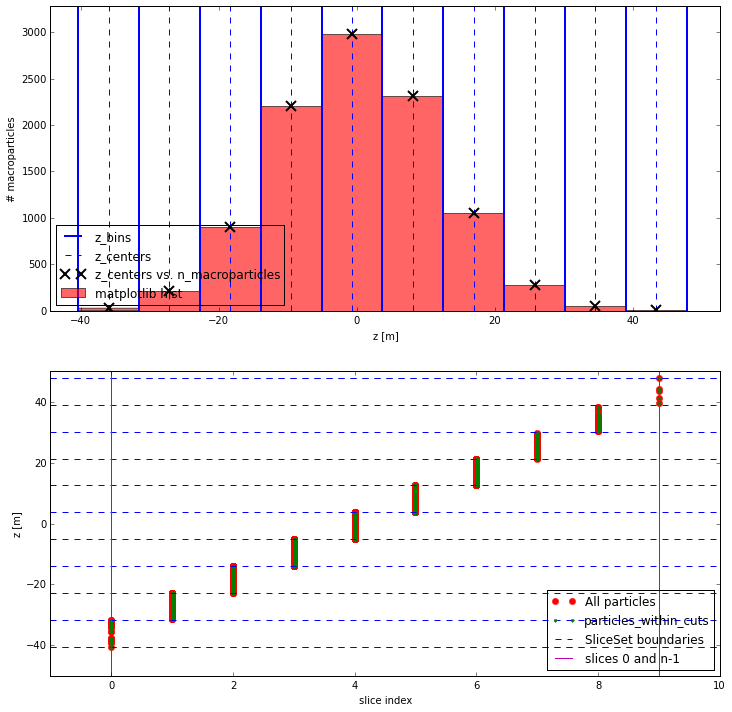

In [15]:
# CASE I
# UniformBinSlicer, no longitudinal cut.
n_slices = 10
n_sigma_z = None
uniform_bin_slicer = UniformBinSlicer(n_slices, n_sigma_z)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_bin_slicer config.
uniform_bin_slice_set = bunch.get_slices(uniform_bin_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_bin(bunch, uniform_bin_slice_set)

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformBinSlicer object at 0x7fab6f9731d0>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7fab6fecc750>}


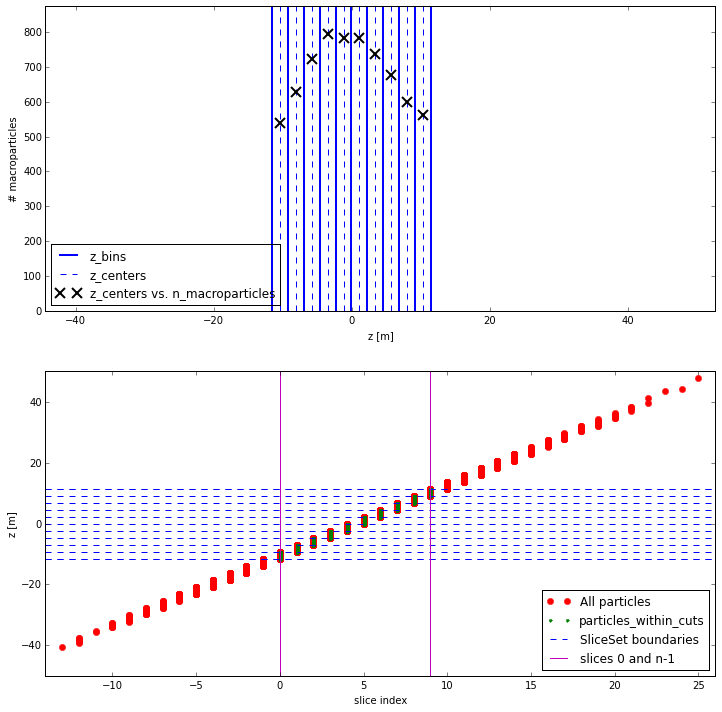

In [16]:
# CASE II
# UniformBinSlicer, n_sigma_z = 1
n_slices = 10
n_sigma_z = 1
uniform_bin_slicer = UniformBinSlicer(n_slices, n_sigma_z)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_bin_slicer config.
uniform_bin_slice_set = bunch.get_slices(uniform_bin_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_bin(bunch, uniform_bin_slice_set)

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformBinSlicer object at 0x7fab6f9f6610>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7fab6f9731d0>}


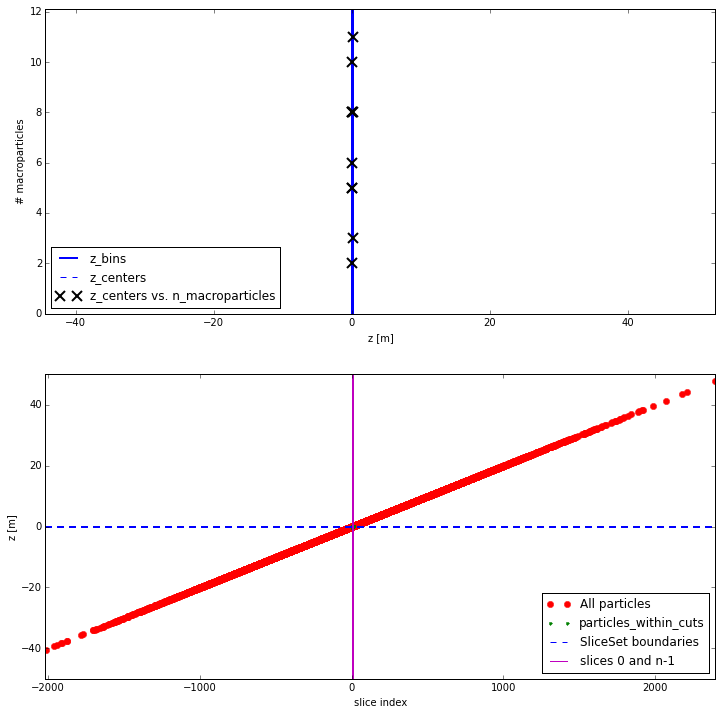

In [17]:
# CASE II b.
# UniformBinSlicer, set z_cuts
n_slices = 10
z_cuts = (-0.05, 0.15)
uniform_bin_slicer = UniformBinSlicer(n_slices, z_cuts=z_cuts)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_bin_slicer config.
uniform_bin_slice_set = bunch.get_slices(uniform_bin_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_bin(bunch, uniform_bin_slice_set)

In [18]:
# CASE II c.
# UniformBinSlicer, set z_cuts and n_sigma_z (THIS SHOULD FAIL).
n_slices = 10
z_cuts = (-0.05, 0.1)
n_sigma_z = 2
try:
    uniform_bin_slicer = UniformBinSlicer(n_slices, n_sigma_z=n_sigma_z, z_cuts=z_cuts)
    raise Exception('Expected ValueError because two incompatible arguments n_sigma_z and z_cuts are given!')
except ValueError:
    print ('Test passed.')

Test passed.


bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformChargeSlicer object at 0x7fab6f8d8b10>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7fab6faeea90>}


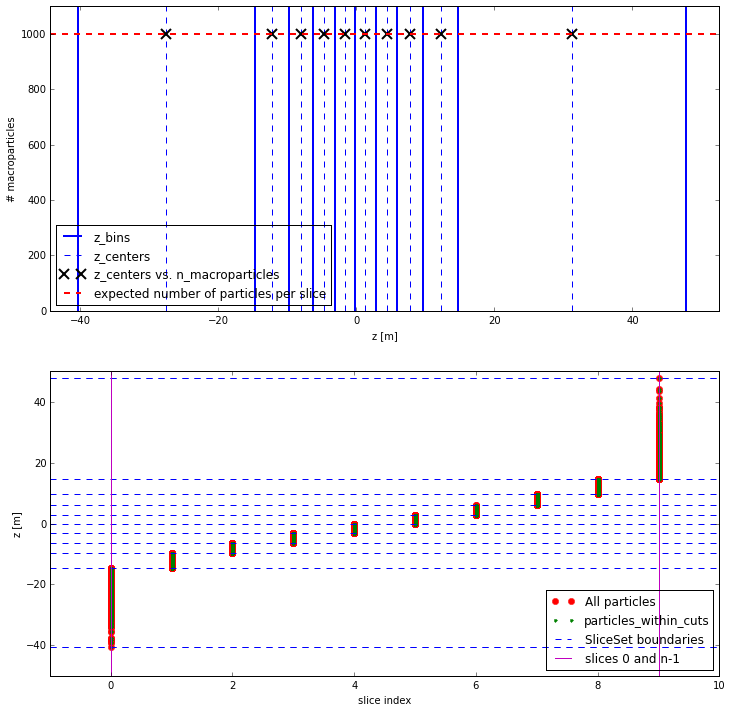

In [19]:
# CASE III
# UniformChargeSlicer, no longitudinal cut.
n_slices = 10
n_sigma_z = None
uniform_charge_slicer = UniformChargeSlicer(n_slices, n_sigma_z)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_charge_slicer config.
uniform_charge_slice_set = bunch.get_slices(uniform_charge_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_charge(bunch, uniform_charge_slice_set)

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformChargeSlicer object at 0x7fab6fd0e610>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7fab6f8d8b10>}


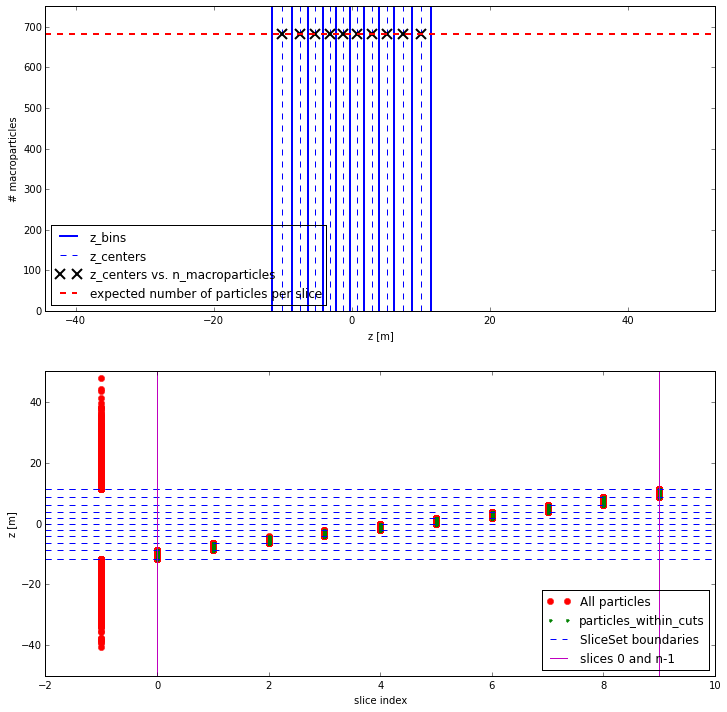

In [20]:
# CASE IV
# UniformChargeSlicer, n_sigma_z = 1
n_slices = 10
n_sigma_z = 1
uniform_charge_slicer = UniformChargeSlicer(n_slices, n_sigma_z)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_charge_slicer config.
uniform_charge_slice_set = bunch.get_slices(uniform_charge_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_charge(bunch, uniform_charge_slice_set)

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformChargeSlicer object at 0x7fab6f848cd0>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7fab6fd0e610>}


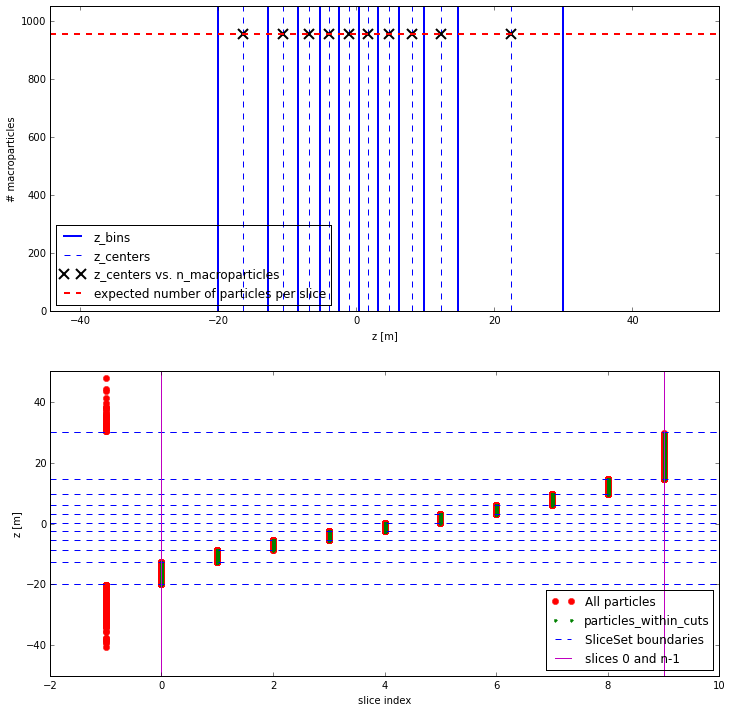

In [21]:
# CASE IV b.
# UniformChargeSlicer, set z_cuts
n_slices = 10
z_cuts = (-20, 30)
uniform_charge_slicer = UniformChargeSlicer(n_slices, z_cuts=z_cuts)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_bin_slicer config.
uniform_charge_slice_set = bunch.get_slices(uniform_charge_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_charge(bunch, uniform_charge_slice_set)